In [118]:
#Milestone project SkimLit



!nvidia-smi


/bin/bash: line 1: nvidia-smi: command not found


In [119]:
#Get the dataset

!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [120]:
#check the files in 20K dataset

!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [121]:
#Start out experiments using the 20k datasets with numbers replaced with @

data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"




In [122]:
#check all the filenames in the target directory

import os

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signdev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtest.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtrain.txt']

In [123]:
#preprocess data

def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()


In [124]:
#Read in the training lines

train_lines = get_lines(data_dir +"/train.txt")
train_lines[:30]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

#Let's think about how we want our data to look like

#how i think out data will look like

# We will try to represent it as a list of dictionaries

[{ 'line_no':0,

'target' : 'OBJECTIVE',

'text':'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthriti',

'total_lines':12}]


In [125]:
def preprocess_text_with_line_numbers(filename):
  input_lines = get_lines(filename)
  abstract_lines = "" #create an empty extract
  abstract_samples = []
  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number , abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_no"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
    else:
      abstract_lines += line
  return abstract_samples






In [126]:
train_samples = preprocess_text_with_line_numbers(data_dir + "/train.txt")
len(train_samples)
val_samples = preprocess_text_with_line_numbers(data_dir + "/dev.txt")
len(val_samples)
test_samples = preprocess_text_with_line_numbers(data_dir + "/test.txt")
len(test_samples)

30135

In [127]:
#Turning the data in the format of a dataframe

import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()


,target,text,line_no,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [128]:
#Distribution of labels

train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


<Axes: ylabel='Frequency'>

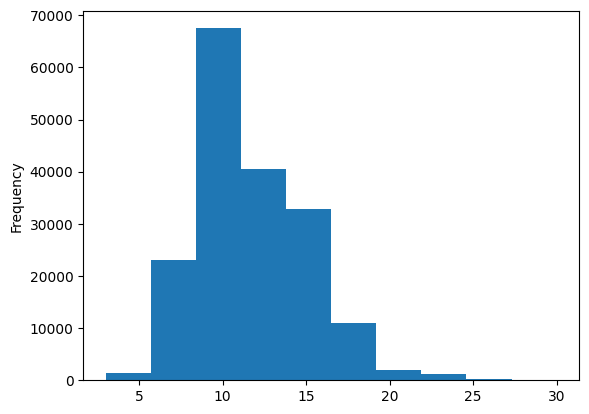

In [129]:
#Lets check the length of different lines

train_df.total_lines.plot.hist()

In [130]:
# Get lists of sentences

#Convert abstract text lines into lists

train_sentences = train_df.text.tolist()
val_sentences = val_df.text.tolist()
test_sentences = test_df.text.tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [131]:
#View the first 10 lines of training sentences

train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [132]:
## Making numeric labels (ML models require numeric labels)

# Lets try one-hot encoding for the labels

from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

In [133]:
# Labels encode labels

# Extract labels ("target" columns ) and encode them into integers

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())


In [134]:
# Get class names and number of classes from LabelEncoder instances

num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Starting to test the Models

# Model - 0 : Lets try the BaseLine Model from sklearn (TF-IDF Multinomial Naive Bayes Classifier)

In [135]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline with TfidfVectorizer and MultinomialNB

model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline on the training data
model_0.fit(train_sentences, train_labels_encoded)



Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [136]:
# Evaluate baseline model on validation dataset

model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [137]:
# Make predictions using our baseline model

baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([4, 1, 3, 2, 2, 2, 2, 2, 4, 4, 0, 4, 1, 1, 2, 2, 4, 1, 4, 4])

In [138]:
#Using the helper function utility script

from helpers_utility import calculate_results

baseline_results = calculate_results(val_labels_encoded, baseline_preds)
baseline_results


{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Model 2: Conv1D Model with Tokenization of Text

## Prepairing our data for deep sequence models

In [139]:
import numpy as np
import tensorflow as tf



In [140]:
# How long is each sentence on average ?

sent_lengths = [len(sent.split()) for sent in train_sentences]
np.mean(sent_lengths), np.max(sent_lengths)

(26.338269273494777, 296)

Text(0.5, 1.0, 'Sentence length distribution')

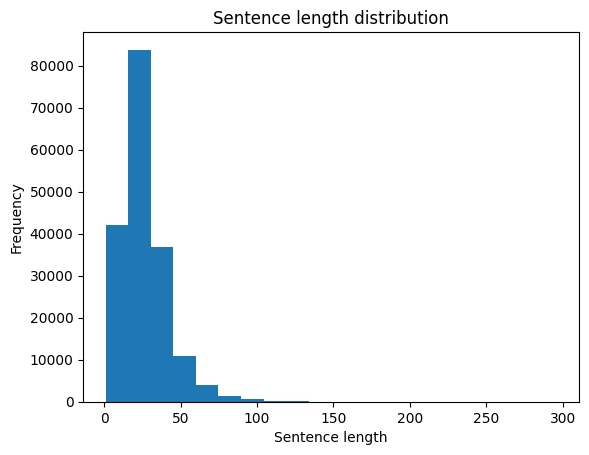

In [141]:
# Whats the distribution look like?

import matplotlib.pyplot as plt
plt.hist(sent_lengths, bins=20)
plt.xlabel("Sentence length")
plt.ylabel("Frequency")
plt.title("Sentence length distribution")

In [142]:
# How long of a sentence len covers 95% of sentences ??

output_seq_len = int(np.percentile(sent_lengths, 95))

### Create a TextVectorizer Layer

## We want to make a layer which converts a text into numbers

In [143]:
# How many unique words are there in our Vocabulary (taken from table 2 in the paper)

max_tokens = 68000



text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

#Adapt it to training data

text_vectorizer.adapt(train_sentences)


In [144]:
#Test out text vectorizer on a random sentence

import random
target_sentence = random.choice(train_sentences)
print(f"Target sentence: \n{target_sentence}\n")
print(f"Length of target sentence: {len(target_sentence.split())}\n")
print(f"Text vectorized: \n{text_vectorizer([target_sentence])}")


Target sentence: 
the objective of this study was to determine the effects of hbo@ by @ months post compression at @ commonly employed dosing levels to treat pcs ; whether specific subgroups may have benefited ; and if no overall effect was found , whether benefit is masked by other conditions .

Length of target sentence: 50

Text vectorized: 
[[    2   367     4    23    17    10     6   228     2    71     4 10737
     22    41   624  1849    15  1261  2696   915    93     6   733  4020
    180   628  1131    91    99  6021     3   324    33   188    70    10
    208   180   398    20  1480    22   168   458     0     0     0     0
      0     0     0     0     0     0     0]]


In [145]:
# How many words in out training vocabulary

rct_20_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20_text_vocab)}")
print(f"Top 5 words: {rct_20_text_vocab[:5]}")
print(f"Bottom 5 words: {rct_20_text_vocab[-5:]}")

Number of words in vocab: 64841
Top 5 words: ['', '[UNK]', 'the', 'and', 'of']
Bottom 5 words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [146]:
#get the config of our text vectorizer

text_vectorizer.get_config()

{'name': 'text_vectorization_1',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

#Create the embeddings

In [147]:
token_embed = tf.keras.layers.Embedding(input_dim=len(rct_20_text_vocab),
                                    output_dim=128,
                                    mask_zero = True,
                                    name="token_embedding")





In [148]:
print(f"Sentence before vectorization:\n {target_sentence}")
print(f"Sentence after vectorization:\n {text_vectorizer([target_sentence])}")
print(f"Sentence after embedding:\n {token_embed(text_vectorizer([target_sentence]))}")
print(f"Sentece shape after embedding:\n {token_embed(text_vectorizer([target_sentence])).shape}")

Sentence before vectorization:
 the objective of this study was to determine the effects of hbo@ by @ months post compression at @ commonly employed dosing levels to treat pcs ; whether specific subgroups may have benefited ; and if no overall effect was found , whether benefit is masked by other conditions .
Sentence after vectorization:
 [[    2   367     4    23    17    10     6   228     2    71     4 10737
     22    41   624  1849    15  1261  2696   915    93     6   733  4020
    180   628  1131    91    99  6021     3   324    33   188    70    10
    208   180   398    20  1480    22   168   458     0     0     0     0
      0     0     0     0     0     0     0]]
Sentence after embedding:
 [[[ 0.02556631  0.03620121  0.00656121 ...  0.02546028  0.02174472
   -0.00412709]
  [-0.01834086 -0.04646299 -0.0303252  ...  0.03647495  0.035332
   -0.04222316]
  [ 0.04880852 -0.00863856  0.03233478 ...  0.01539803  0.01875151
   -0.04122133]
  ...
  [ 0.04837451 -0.00315664  0.044760

## Creating datasets (making sure our data loads as fast as possible)



In [149]:
# Turn our data into tensorflow datasets

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [150]:
# Take the tensorslicedataset and turn them into prefetched datasets

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Model 1: Conv1D Model




In [151]:
inputs = tf.keras.layers.Input(shape =(1,),dtype = tf.string)
x = text_vectorizer(inputs)
x = token_embed(x)
x = tf.keras.layers.Conv1D(filters = 64, kernel_size = 5,padding="same", activation = "relu")(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
outputs = tf.keras.layers.Dense(num_classes, activation = "softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)
model_1.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'conv1d_2' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 55)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_embedding (Embedding)          │ (None, 55, 128)             │       8,299,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 55, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_2               │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [152]:
model_1.compile(loss ="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])


In [153]:
history_model_1 = model_1.fit(train_dataset,steps_per_epoch=int(0.1*len(train_dataset)),epochs = 3,validation_data = val_dataset,validation_steps = int(0.1*len(val_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 71s 122ms/step - accuracy: 0.5709 - loss: 1.0944 - val_accuracy: 0.7859 - val_loss: 0.5814
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 69s 122ms/step - accuracy: 0.7849 - loss: 0.5897 - val_accuracy: 0.8009 - val_loss: 0.5192
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 70s 125ms/step - accuracy: 0.8003 - loss: 0.5442 - val_accuracy: 0.8032 - val_loss: 0.5110


In [154]:
# Evaluate on the whole dataset

model_1.evaluate(val_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8077 - loss: 0.5150


[0.5198372006416321, 0.8066662549972534]

In [155]:
# Make predictions (our model predicts the prediction for each class)

model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


array([[5.7907492e-01, 3.8688011e-02, 1.5691515e-03, 3.7905031e-01,
        1.6176446e-03],
       [2.7294752e-01, 5.6131709e-01, 1.8263427e-03, 1.6204365e-01,
        1.8653715e-03],
       [1.4558016e-01, 1.1753861e-02, 1.3705160e-03, 8.4119827e-01,
        9.7297649e-05],
       ...,
       [2.2540730e-04, 1.5936305e-03, 1.1004784e-02, 3.4240822e-04,
        9.8683375e-01],
       [2.5446333e-02, 6.2434435e-01, 3.5092697e-02, 2.5497619e-02,
        2.8961891e-01],
       [1.7529596e-02, 9.7696835e-01, 6.6814740e-04, 3.2469272e-03,
        1.5869417e-03]], dtype=float32)

In [156]:
# Convert pred_probs to classes

model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 1, 1])>

In [157]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [158]:
model_1_results = calculate_results(val_labels_encoded, model_1_preds)
model_1_results

{'accuracy': 80.66662253409241,
 'precision': 0.8051720115662248,
 'recall': 0.8066662253409241,
 'f1': 0.805264110174575}

## Model 2: Feature extraction with pretrained token embeddings

##Using Universal Sentence Encoder




In [159]:
#Download pretrained Tensorflow Hub USE

import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                    trainable = False,
                                    name = "universal_sentence_encoder")



In [160]:
random_train_sentence = random.choice(train_sentences)
print(f"Original sentence: \n{random_train_sentence}\n")
print(f"Sentence after embedding: \n{tf_hub_embedding_layer([random_train_sentence])}")
print(f"Length of sentence embedding : {len(tf_hub_embedding_layer([random_train_sentence])[0])}")

Original sentence: 
university hospital .

Sentence after embedding: 
[[-6.48239627e-02  8.69399868e-03 -1.26937274e-02  1.51241031e-02
   6.45598546e-02  6.04877174e-02  5.99215142e-02  5.46964165e-03
  -4.53358591e-02 -8.65971968e-02  8.42348486e-02  2.23292764e-02
  -2.47278400e-02 -1.41067933e-02  1.35590509e-02 -6.54952042e-03
  -8.64183903e-02 -1.53365992e-02 -3.13519314e-02 -8.68770257e-02
   1.95566397e-02  5.83010577e-02  7.64819756e-02  5.20794876e-02
   1.27391703e-03 -6.09818660e-03  3.74277011e-02  2.75611896e-02
   1.43528087e-02 -1.75183837e-03 -1.84207689e-02  8.70099217e-02
   3.32018659e-02 -1.58775765e-02 -3.39781828e-02  3.09490580e-02
   5.71057294e-03  6.87982813e-02 -8.34447518e-02  2.33874619e-02
  -2.90879235e-02 -6.01167008e-02 -3.11134495e-02 -4.88084555e-02
   3.52494195e-02 -1.29032582e-02 -4.14224714e-02  5.17773367e-02
   7.27983862e-02 -2.12393031e-02 -4.23226692e-02  7.13320300e-02
   4.65722047e-02  2.73956847e-03  4.21922058e-02 -5.90339638e-02
   4.8

In [161]:
#Building and fitting and NLP feature extraction model using pretrained embeddings
from tensorflow.keras.optimizers.legacy import Adam


class MyLayer(tf.keras.layers.Layer):
    def call(self, x):
        with tf.device('/CPU:0'):  # Force the embedding to run on CPU
            return tf_hub_embedding_layer(x)



inputs = tf.keras.layers.Input(shape = [], dtype = tf.string)
pretrained_embedding = MyLayer()(inputs)
x = tf.keras.layers.Dense(128, activation = "relu")(pretrained_embedding)
outputs = tf.keras.layers.Dense(num_classes, activation = "softmax")(x)
model_2 = tf.keras.Model(inputs, outputs,name ="model_2_USE_feature_extractor")


model_2.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])



model_2.summary()

Model: "model_2_USE_feature_extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None)                      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ my_layer_4 (MyLayer)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,309 (259.02 KB)

 Trainable params: 66,309 (259.02 KB)

 Non-trainable params: 0 (0.00 B)

In [162]:
history_model_2 = model_2.fit(train_dataset,steps_per_epoch=int(0.1*len(train_dataset)),epochs = 3,validation_data = val_dataset,validation_steps = int(0.1*len(val_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.5854 - loss: 1.0960 - val_accuracy: 0.6902 - val_loss: 0.7952
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.7030 - loss: 0.7716 - val_accuracy: 0.7071 - val_loss: 0.7558
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.7140 - loss: 0.7547 - val_accuracy: 0.7184 - val_loss: 0.7276


In [163]:
model_2.evaluate(val_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.7145 - loss: 0.7387


[0.7405805587768555, 0.713954746723175]

In [164]:
#Make some predictions with feature extraction model

model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step


array([[4.2262292e-01, 3.8408995e-01, 1.7346974e-03, 1.8453279e-01,
        7.0195906e-03],
       [3.2340911e-01, 5.3504157e-01, 3.3951562e-03, 1.3560705e-01,
        2.5470459e-03],
       [2.3202670e-01, 1.4912958e-01, 1.4938294e-02, 5.5988121e-01,
        4.4024218e-02],
       ...,
       [2.1508404e-03, 6.4957622e-03, 5.5477753e-02, 8.4307953e-04,
        9.3503255e-01],
       [4.3751574e-03, 4.5962237e-02, 2.2014625e-01, 1.5286120e-03,
        7.2798777e-01],
       [1.7405500e-01, 2.7897501e-01, 4.9131408e-01, 8.9759119e-03,
        4.6680018e-02]], dtype=float32)

In [165]:
#convert the predictions probabilities with feature extraction model to labels

model_2_preds = tf.argmax(model_2_pred_probs, axis = 1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [166]:
#Calcuate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

{'accuracy': 71.39547199788163,
 'precision': 0.7139121564838401,
 'recall': 0.7139547199788163,
 'f1': 0.7109663844785422}

# Model 3: Conv1D with Character Embeddeings
# The paper states they used a combination of character level embeddings
# Charcter level embedding embeds each character, where as token level does one word at a time


# We have to tokenize our data in character level
# Like Example: "I love tensorflow"
# should be like : [I, ,l,o,v,e, ,t,e,s,o,r,f,l,o,w]



In [167]:
#Create a chr level tokenizer

train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [168]:
#Function to split sentences into characters

def split_chars(text):
  return " ".join(list(text))

In [169]:
" ".join(list(train_sentences[0]))

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [170]:
train_chars = [split_chars(text) for text in train_sentences]
val_chars = [split_chars(text) for text in val_sentences]
test_chars = [split_chars(text) for text in test_sentences]

In [171]:
train_chars[:2]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .']

# Whats the avg character length,lets check

In [172]:
chars_lens = [len(sentence) for sentence in train_sentences]
mean_chars_len = np.mean(chars_lens)
max_chars_len = np.max(chars_lens)
mean_chars_len, max_chars_len

(149.3662574983337, 1386)

(array([2.2108e+04, 7.0583e+04, 5.3952e+04, 2.2391e+04, 7.4540e+03,
        2.2350e+03, 8.0200e+02, 2.8700e+02, 1.1800e+02, 4.9000e+01,
        2.9000e+01, 1.3000e+01, 8.0000e+00, 5.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 7.02500e+01, 1.39500e+02, 2.08750e+02, 2.78000e+02,
        3.47250e+02, 4.16500e+02, 4.85750e+02, 5.55000e+02, 6.24250e+02,
        6.93500e+02, 7.62750e+02, 8.32000e+02, 9.01250e+02, 9.70500e+02,
        1.03975e+03, 1.10900e+03, 1.17825e+03, 1.24750e+03, 1.31675e+03,
        1.38600e+03]),
 <BarContainer object of 20 artists>)

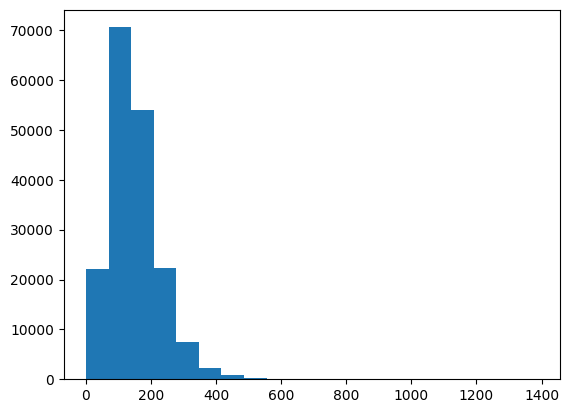

In [173]:
#Check the distribution of the data

import matplotlib.pyplot as plt

plt.hist(chars_lens, bins = 20)

In [174]:
# Find what character len covers 95 percentile

output_seq_char_len = int(np.percentile(chars_lens, 95))
output_seq_char_len

290

In [175]:
# Get all keyboard characters

random.choice(train_sentences)

'the diagnosis of sd during examination is based primarily on auditory cues .'

In [176]:
import string

alphabet = string.ascii_lowercase + " " + string.punctuation

In [177]:
len(alphabet)

59

In [178]:
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = tf.keras.layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                output_sequence_length = output_seq_char_len,
                                                    standardize = "lower_and_strip_punctuation",
                                    name ="char_vectorizer")

#Adapt it

char_vectorizer.adapt(train_chars)

In [179]:
char_vocab = char_vectorizer.get_vocabulary()

In [180]:
print(f"Number of characters in vocab: {len(char_vocab)}")
print(f"First 5 characters: {char_vocab[:5]}")
print(f"Last 5 characters: {char_vocab[-5:]}")


Number of characters in vocab: 28
First 5 characters: ['', '[UNK]', 'e', 't', 'i']
Last 5 characters: ['k', 'x', 'z', 'q', 'j']


In [181]:
# Test

random_text_chars = random.choice(train_chars)
print(f"Original text: \n{random_text_chars}\n")
print(f"Vectorized text: \n{char_vectorizer([random_text_chars])}")
print(f"Length of vectorized text: {len(char_vectorizer([random_text_chars])[0])}")

Original text: 
t h e   p r i m a r y   e n d   p o i n t s   a r e   t h e   d e v e l o p m e n t   o f   h c c   a n d   l i v e r - r e l a t e d   d e a t h   .

Vectorized text: 
[[ 3 13  2 14  8  4 15  5  8 19  2  6 10 14  7  4  6  3  9  5  8  2  3 13
   2 10  2 21  2 12  7 14 15  2  6  3  7 17 13 11 11  5  6 10 12  4 21  2
   8  8  2 12  5  3  2 10 10  2  5  3 13  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 

# Now lets create a character level Embedding

In [182]:
## Creating a character level embedding

char_embed = tf.keras.layers.Embedding(input_dim = len(char_vocab),
                                    output_dim = 25, #this is the size of the char embedding in the paper
                                    mask_zero = True,
                                    name = "char_embedding")

In [183]:
#Test out character embedding layer

print(f"Original text: \n{random_text_chars}\n")
print(f"Vectorized text: \n{char_vectorizer([random_text_chars])}\n")
print(f"Embedded text: \n{char_embed(char_vectorizer([random_text_chars]))}")
print(f"Embedded text shape: \n{char_embed(char_vectorizer([random_text_chars])).shape}")

Original text: 
t h e   p r i m a r y   e n d   p o i n t s   a r e   t h e   d e v e l o p m e n t   o f   h c c   a n d   l i v e r - r e l a t e d   d e a t h   .

Vectorized text: 
[[ 3 13  2 14  8  4 15  5  8 19  2  6 10 14  7  4  6  3  9  5  8  2  3 13
   2 10  2 21  2 12  7 14 15  2  6  3  7 17 13 11 11  5  6 10 12  4 21  2
   8  8  2 12  5  3  2 10 10  2  5  3 13  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 

In [184]:
## Building a Conv1D model to fit a character embedding

## Make conv1d on chars only

inputs = tf.keras.layers.Input(shape = (1,), dtype = tf.string)
x = char_vectorizer(inputs)
x = char_embed(x)
x = tf.keras.layers.Conv1D(filters = 64, kernel_size = 5, padding = "same", activation = "relu")(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
outputs = tf.keras.layers.Dense(num_classes, activation = "softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name = "model")

model_3.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

model_3.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'conv1d_3' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ char_vectorizer (TextVectorization)  │ (None, 290)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ char_embedding (Embedding)           │ (None, 290, 25)             │             700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 290, 64)             │           8,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_3               │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

In [185]:
## For faster data loading we need to make it fast in case of char level encoding also

train_dataset_char = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset_char = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset_char = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)





In [186]:
# Fit the model

model_3_history = model_3.fit(train_dataset_char, steps_per_epoch = int(0.1*len(train_dataset_char)), epochs = 3, validation_data = val_dataset_char, validation_steps = int(0.1*len(val_dataset_char)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.4184 - loss: 1.3989 - val_accuracy: 0.5878 - val_loss: 1.0465
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5853 - loss: 1.0330 - val_accuracy: 0.6420 - val_loss: 0.9286
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.6320 - loss: 0.9305 - val_accuracy: 0.6582 - val_loss: 0.8818


In [187]:
#Evaluate the model

model_3.evaluate(val_dataset_char)


945/945 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.6554 - loss: 0.8828


[0.8827599883079529, 0.6564279198646545]

In [188]:
#Convert probs to class labels

model_3_preds = tf.argmax(model_3.predict(val_dataset_char), axis = 1)
model_3_preds

945/945 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 3, ..., 4, 2, 1])>

In [189]:

model_3_pred_probs = model_3.predict(val_dataset_char)
model_3_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step


array([[0.19748491, 0.30832273, 0.11066732, 0.32541373, 0.05811127],
       [0.2014457 , 0.5726662 , 0.03719347, 0.15955594, 0.02913875],
       [0.07805847, 0.21799535, 0.26417422, 0.30588502, 0.13388689],
       ...,
       [0.01327446, 0.01379418, 0.11658322, 0.0194716 , 0.8368766 ],
       [0.02915783, 0.09451156, 0.47224867, 0.0479926 , 0.35608926],
       [0.31503397, 0.4824187 , 0.11458434, 0.07766798, 0.01029505]],
      dtype=float32)

In [190]:
model_3_results = calculate_results(val_labels_encoded, model_3_preds)
model_3_results

{'accuracy': 65.64279094399576,
 'precision': 0.6513994441634023,
 'recall': 0.6564279094399577,
 'f1': 0.6481304823916829}

  ## Model 4 : Combining pretrained token embeddings + characters embeddings (hybrid model)

  1. Creating a token level embedding model
  2. Creating a character level model
  3. concatenate (layers.Concatenate)
  4.Build a series of output layers
  5. Construct a model which takes token and character level sequences as input and produces sequence level probabilities as output

  

In [191]:


class MyLayer(tf.keras.layers.Layer):
    def call(self, x):
        return tf_hub_embedding_layer(x)

token_inputs = tf.keras.layers.Input(shape = [], dtype = tf.string, name = "token_inputs")
token_embeddings = MyLayer()(token_inputs)
token_output = tf.keras.layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs, outputs = token_output)


char_inputs = tf.keras.layers.Input(shape = (1,), dtype = tf.string, name = "char_inputs")
char_embeddings = char_embed(char_vectorizer(char_inputs))
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs, outputs = char_bi_lstm)


token_char_concat = tf.keras.layers.Concatenate(name = "token_char_concat")([token_model.output, char_model.output])


combined_dropout = tf.keras.layers.Dropout(0.5)(token_char_concat)
combined_dense = tf.keras.layers.Dense(128, activation = "relu")(combined_dropout)
final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)
output_layer = tf.keras.layers.Dense(num_classes, activation = "softmax")(final_dropout)

hybrid_model = tf.keras.Model(inputs = [token_model.input, char_model.input], outputs = output_layer, name ="hybrid_model")


hybrid_model.compile(loss = "categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ["accuracy"])

hybrid_model.summary()






Model: "hybrid_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_inputs (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_inputs (InputLayer) │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_vectorizer           │ (None, 290)            │              0 │ char_inputs[0][0]      │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ my_layer_5 (MyLayer)      │ (None, 512)            │              0 │ token_inputs[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_embedding            │ (None, 290, 25)        │            700 │ char_vectorizer[1][0]  │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_5 (NotEqual)    │ (None, 290)            │              0 │ char_vectorizer[1][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 128)            │         65,664 │ my_layer_5[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 48)             │          9,600 │ char_embedding[1][0],  │
│ (Bidirectional)           │                        │                │ not_equal_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_concat         │ (None, 176)            │              0 │ dense_11[0][0],        │
│ (Concatenate)             │                        │                │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 176)            │              0 │ token_char_concat[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 128)            │         22,656 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 5)              │            645 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 99,265 (387.75 KB)

 Trainable params: 99,265 (387.75 KB)

 Non-trainable params: 0 (0.00 B)

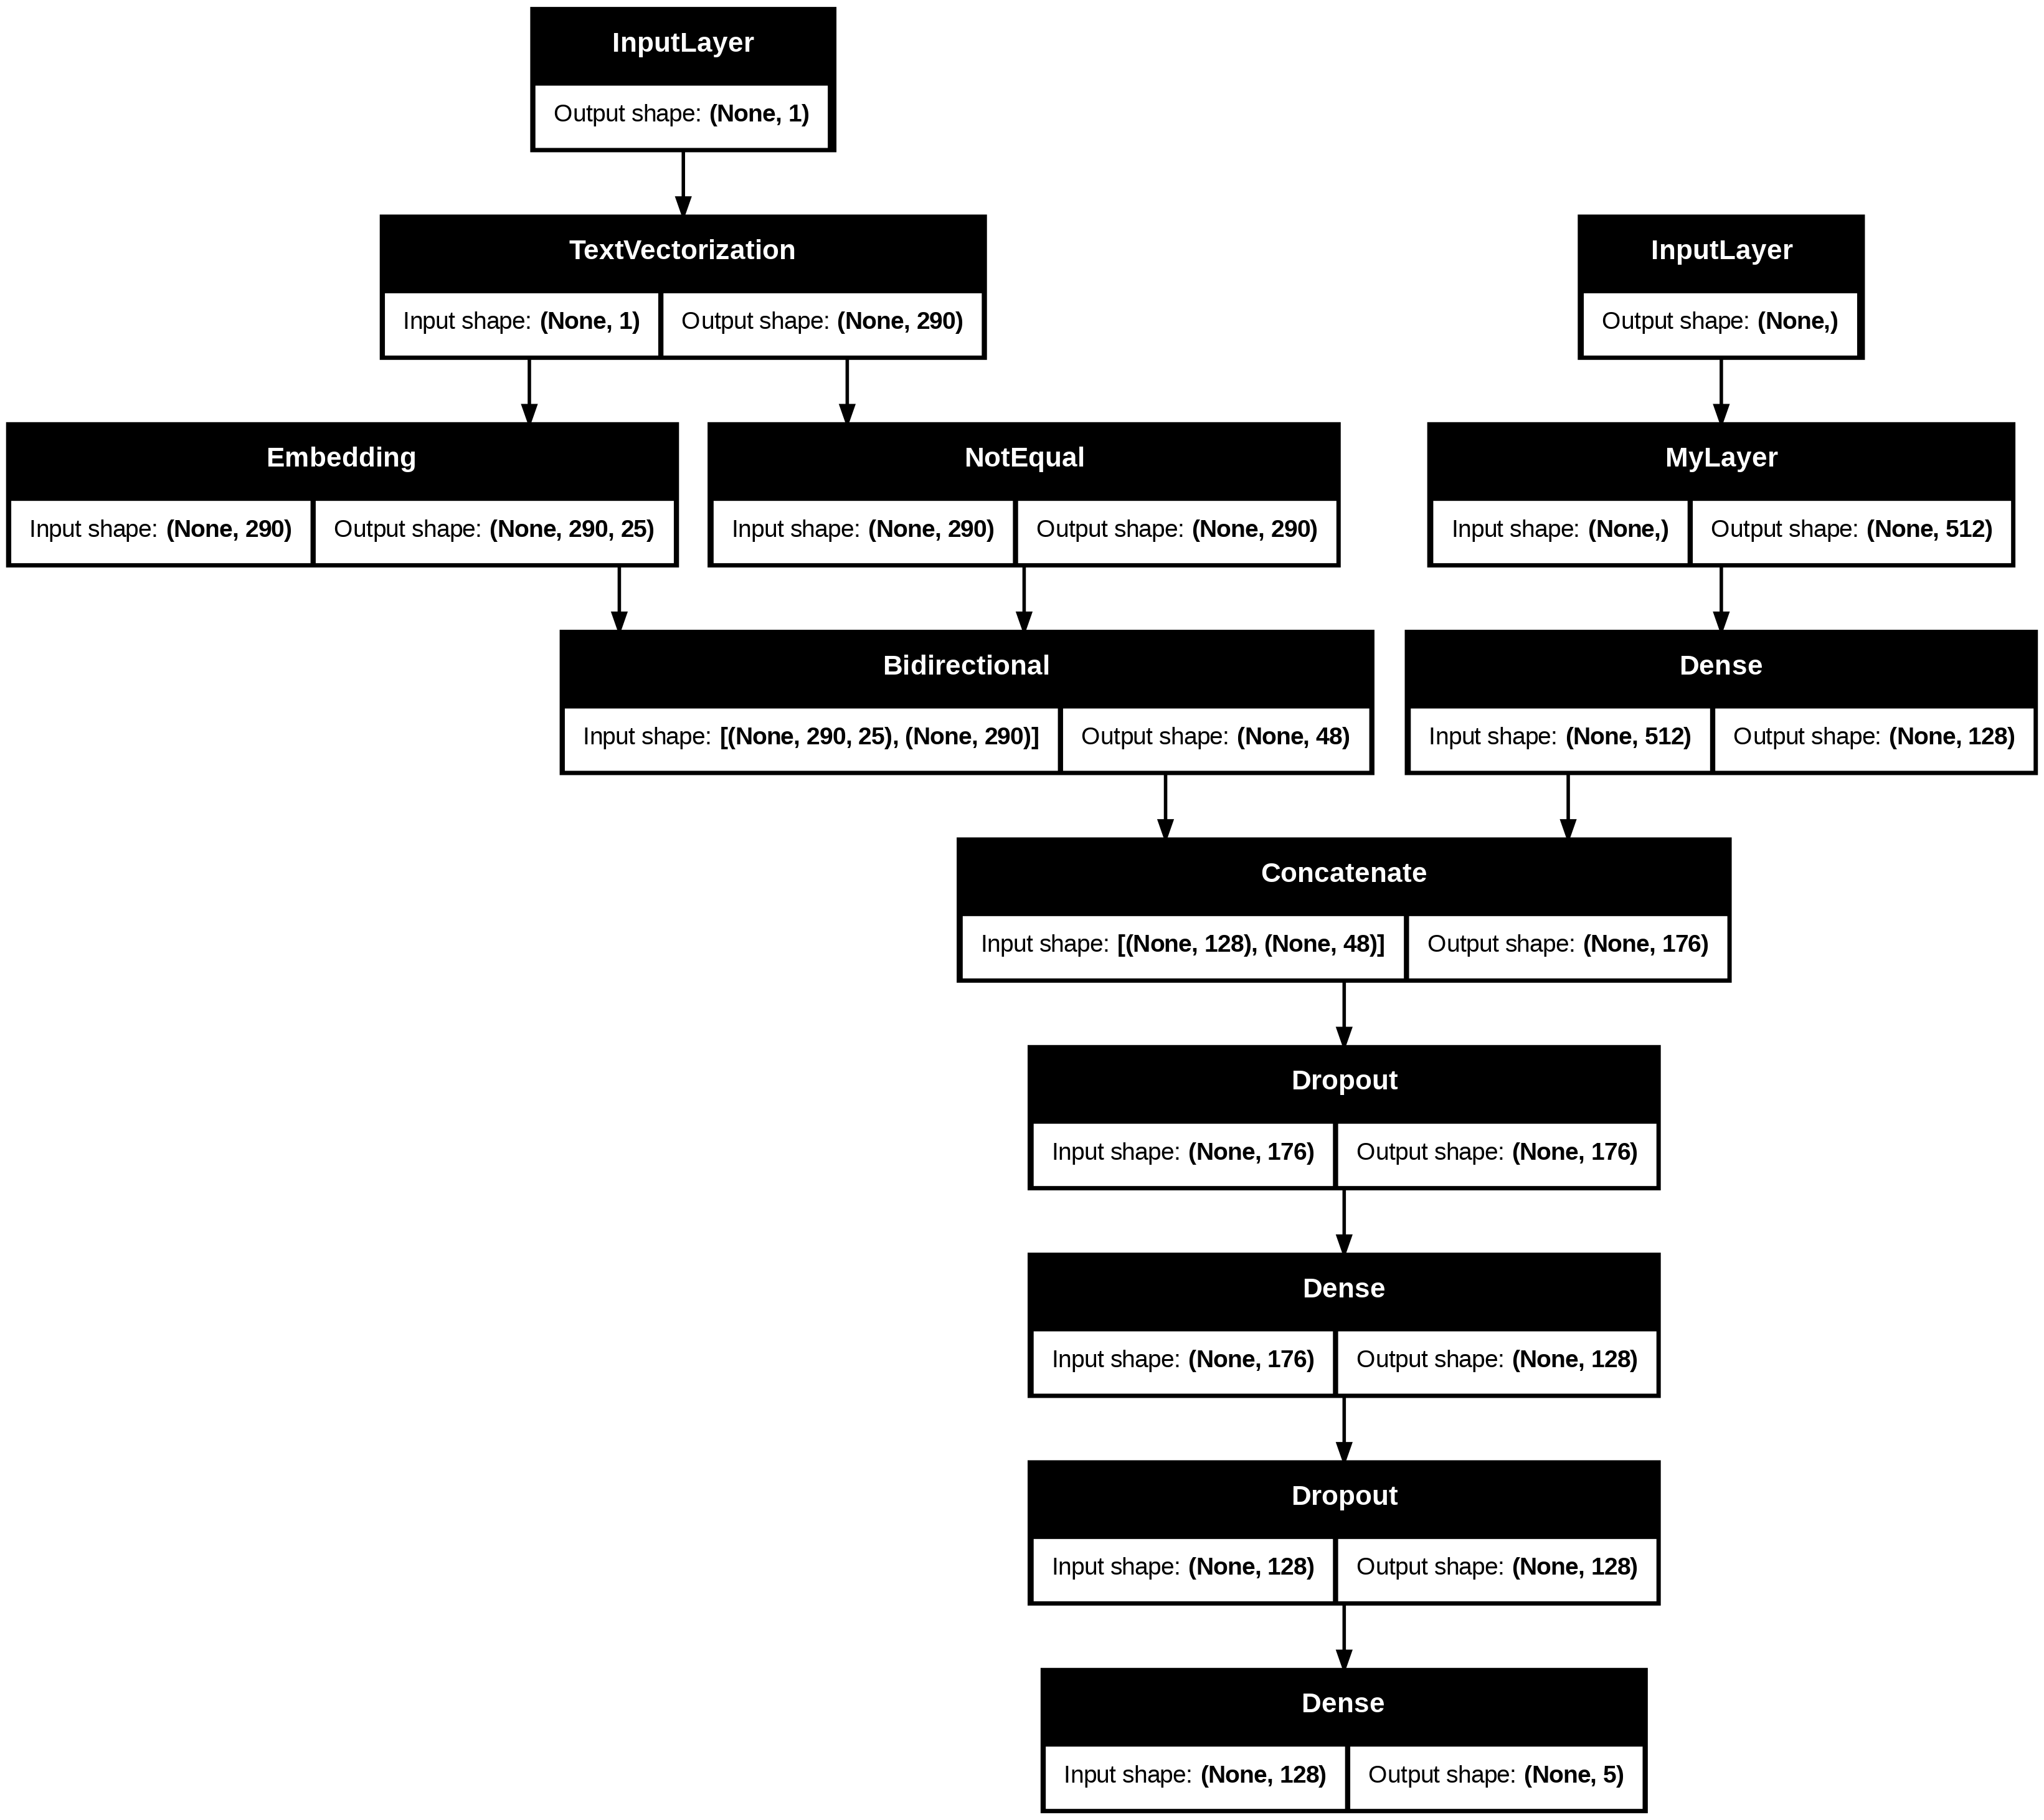

In [192]:
# Another visualisation of model

from keras.utils import plot_model
plot_model(hybrid_model,show_shapes=True)

### Combining token and char data into tf.data Dataset

In [193]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_dataset, val_char_token_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_char_token_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_dataset, test_char_token_labels))

test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [194]:
train_char_token_dataset,var_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [195]:
history_hybrid_model = hybrid_model.fit(train_char_token_dataset, steps_per_epoch = int(0.1*len(train_char_token_dataset)), epochs = 3, validation_data = var_char_token_dataset)

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 260s 449ms/step - accuracy: 0.5128 - loss: 1.1635 - val_accuracy: 0.6962 - val_loss: 0.7889
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 250s 445ms/step - accuracy: 0.6909 - loss: 0.8111 - val_accuracy: 0.7231 - val_loss: 0.7268
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 270s 481ms/step - accuracy: 0.7068 - loss: 0.7796 - val_accuracy: 0.7331 - val_loss: 0.6973


In [196]:
# Evaluate

hybrid_model.evaluate(val_char_token_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 72s 76ms/step - accuracy: 0.7334 - loss: 0.6956


[0.6972997784614563, 0.7331193089485168]

In [197]:
# Make predictions

hybrid_model_pred_probs = hybrid_model.predict(val_char_token_dataset)
hybrid_model_pred_probs

hybrid_model_results = calculate_results(val_labels_encoded, tf.argmax(hybrid_model_pred_probs, axis = 1))
hybrid_model_results

945/945 ━━━━━━━━━━━━━━━━━━━━ 70s 74ms/step


{'accuracy': 73.3119290348206,
 'precision': 0.7310253140966226,
 'recall': 0.733119290348206,
 'f1': 0.7296832846769786}

# Model 5: TOKEN EMBEDDING + CHAR EMBEDDINGS + POSITIONAL EMBEDDING

# Since in a paper the order of a abstract matters so we need to add a extra layer of positional EMbeddings( Which we will do using the line_no feature)

## BACKGROUND -> METHODS -> CONCLUSION

In [198]:
train_df.head()

,target,text,line_no,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


# Any engineered features used to train the model needs to be available in the test time(run time of a model)



In [199]:
# Create positional embeddings

#How many different line numbers are there

train_df["line_no"].value_counts()

,count
line_no,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


<Axes: ylabel='Frequency'>

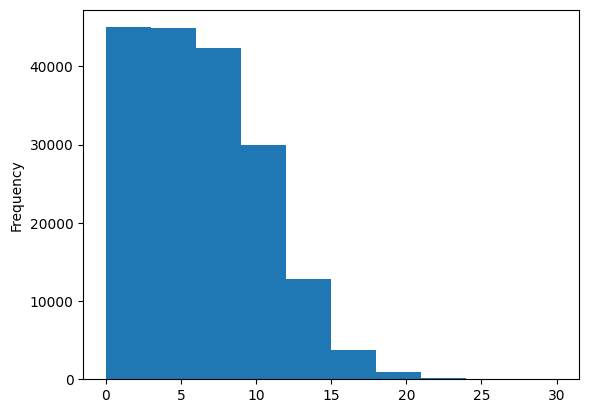

In [200]:
# Chek the disbn

train_df.line_no.plot.hist()

In [203]:
# USe tensorflow to create one-hot encodded tensors of our line_no

train_line_numbers_one_hot = tf.one_hot(train_df["line_no"], depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_no"], depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_no"], depth = 15)
train_line_numbers_one_hot

<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [204]:
  #Let's do the same for total_lines feature.

  train_df["total_lines"].value_counts()

,count
total_lines,
11,24468
10,23639
12,22113
9,19400
13,18438
14,14610
8,12285
15,10768
7,7464


<Axes: ylabel='Frequency'>

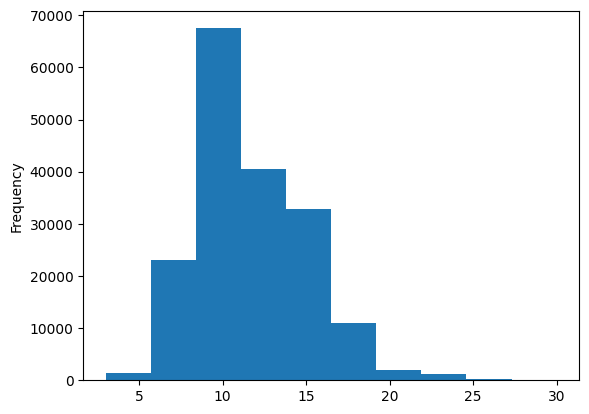

In [206]:
train_df.total_lines.plot.hist()

In [208]:
# Check the coverage of the 95 percentile of it

np.percentile(train_df["total_lines"], 98)

20.0

In [211]:
#Using tensorflow to create the one-hot tensor of our total_line feature

train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth = 20)


In [210]:
train_total_lines_one_hot

<tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

### Building a Tribrid embedding model

1. create a token level model
2. create a character-level model
3. create a model for the "line number " feature
4. create a model for the "total lines" features
5. combine the outputs of 1 & 2
6. combine the outputs of 3,4 & 5
7. create an output layer to accept the tribrid embedding and output label probabilities
8. combine the inputs of 1,2,3,4 and outputs of tf.keras.Model

In [253]:
class MyLayer(tf.keras.layers.Layer):
    def call(self, x):
        return tf_hub_embedding_layer(x)

token_inputs = tf.keras.layers.Input(shape = [], dtype = tf.string, name = "token_inputs")
token_embeddings = MyLayer()(token_inputs)
token_output = tf.keras.layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs, outputs = token_output)

char_inputs = tf.keras.layers.Input(shape = (1,), dtype = tf.string, name = "char_inputs")
char_embeddings = char_embed(char_vectorizer(char_inputs))
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs, outputs = char_bi_lstm)

line_number_inputs = tf.keras.layers.Input(shape = (15,), dtype = tf.float32, name = "line_number_inputs")
line_number_dense = tf.keras.layers.Dense(32, activation = "relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs, outputs = line_number_dense)

total_lines_inputs = tf.keras.layers.Input(shape = (20,), dtype = tf.float32, name = "total_lines_inputs")
total_lines_dense = tf.keras.layers.Dense(32, activation = "relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs = total_lines_inputs, outputs = total_lines_dense)


token_char_concat = tf.keras.layers.Concatenate(name = "token_char_concat")([token_model.output, char_model.output])

z = tf.keras.layers.Dense(256, activation = "relu")(token_char_concat)
z = tf.keras.layers.Dropout(0.5)(z)

tribrid_embeddings = tf.keras.layers.Concatenate(name = "tribrid_embeddings")([ line_number_model.output, total_lines_model.output, z])

output_layer = tf.keras.layers.Dense(num_classes, activation = "softmax",name ="output_layer")(tribrid_embeddings)

tribrid_model = tf.keras.Model(inputs = [line_number_model.input, total_lines_model.input, token_model.input, char_model.input], outputs = output_layer, name = "tribrid_model")

In [220]:
tribrid_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), #label_smoothing helps prevent overfitting
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ["accuracy"])

tribrid_model.summary()

Model: "tribrid_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_inputs (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_inputs (InputLayer) │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_vectorizer           │ (None, 290)            │              0 │ char_inputs[0][0]      │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ my_layer_7 (MyLayer)      │ (None, 512)            │              0 │ token_inputs[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_embedding            │ (None, 290, 25)        │            700 │ char_vectorizer[3][0]  │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_7 (NotEqual)    │ (None, 290)            │              0 │ char_vectorizer[3][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 128)            │         65,664 │ my_layer_7[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 48)             │          9,600 │ char_embedding[3][0],  │
│ (Bidirectional)           │                        │                │ not_equal_7[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_concat         │ (None, 176)            │              0 │ dense_18[0][0],        │
│ (Concatenate)             │                        │                │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ line_number_inputs        │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ total_lines_inputs        │ (None, 20)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 256)            │         45,312 │ token_char_concat[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (None, 32)             │            512 │ line_number_inputs[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_20 (Dense)          │ (None, 32)             │            672 │ total_lines_inputs[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 256)            │              0 │ dense_21[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tribrid_embeddings        │ (None, 320)            │              0 │ dense_19[0][0],        │
│ (Concatenate)             │                        │                │ dense_20[0][0],        │
│                      

 Total params: 124,065 (484.63 KB)

 Trainable params: 124,065 (484.63 KB)

 Non-trainable params: 0 (0.00 B)

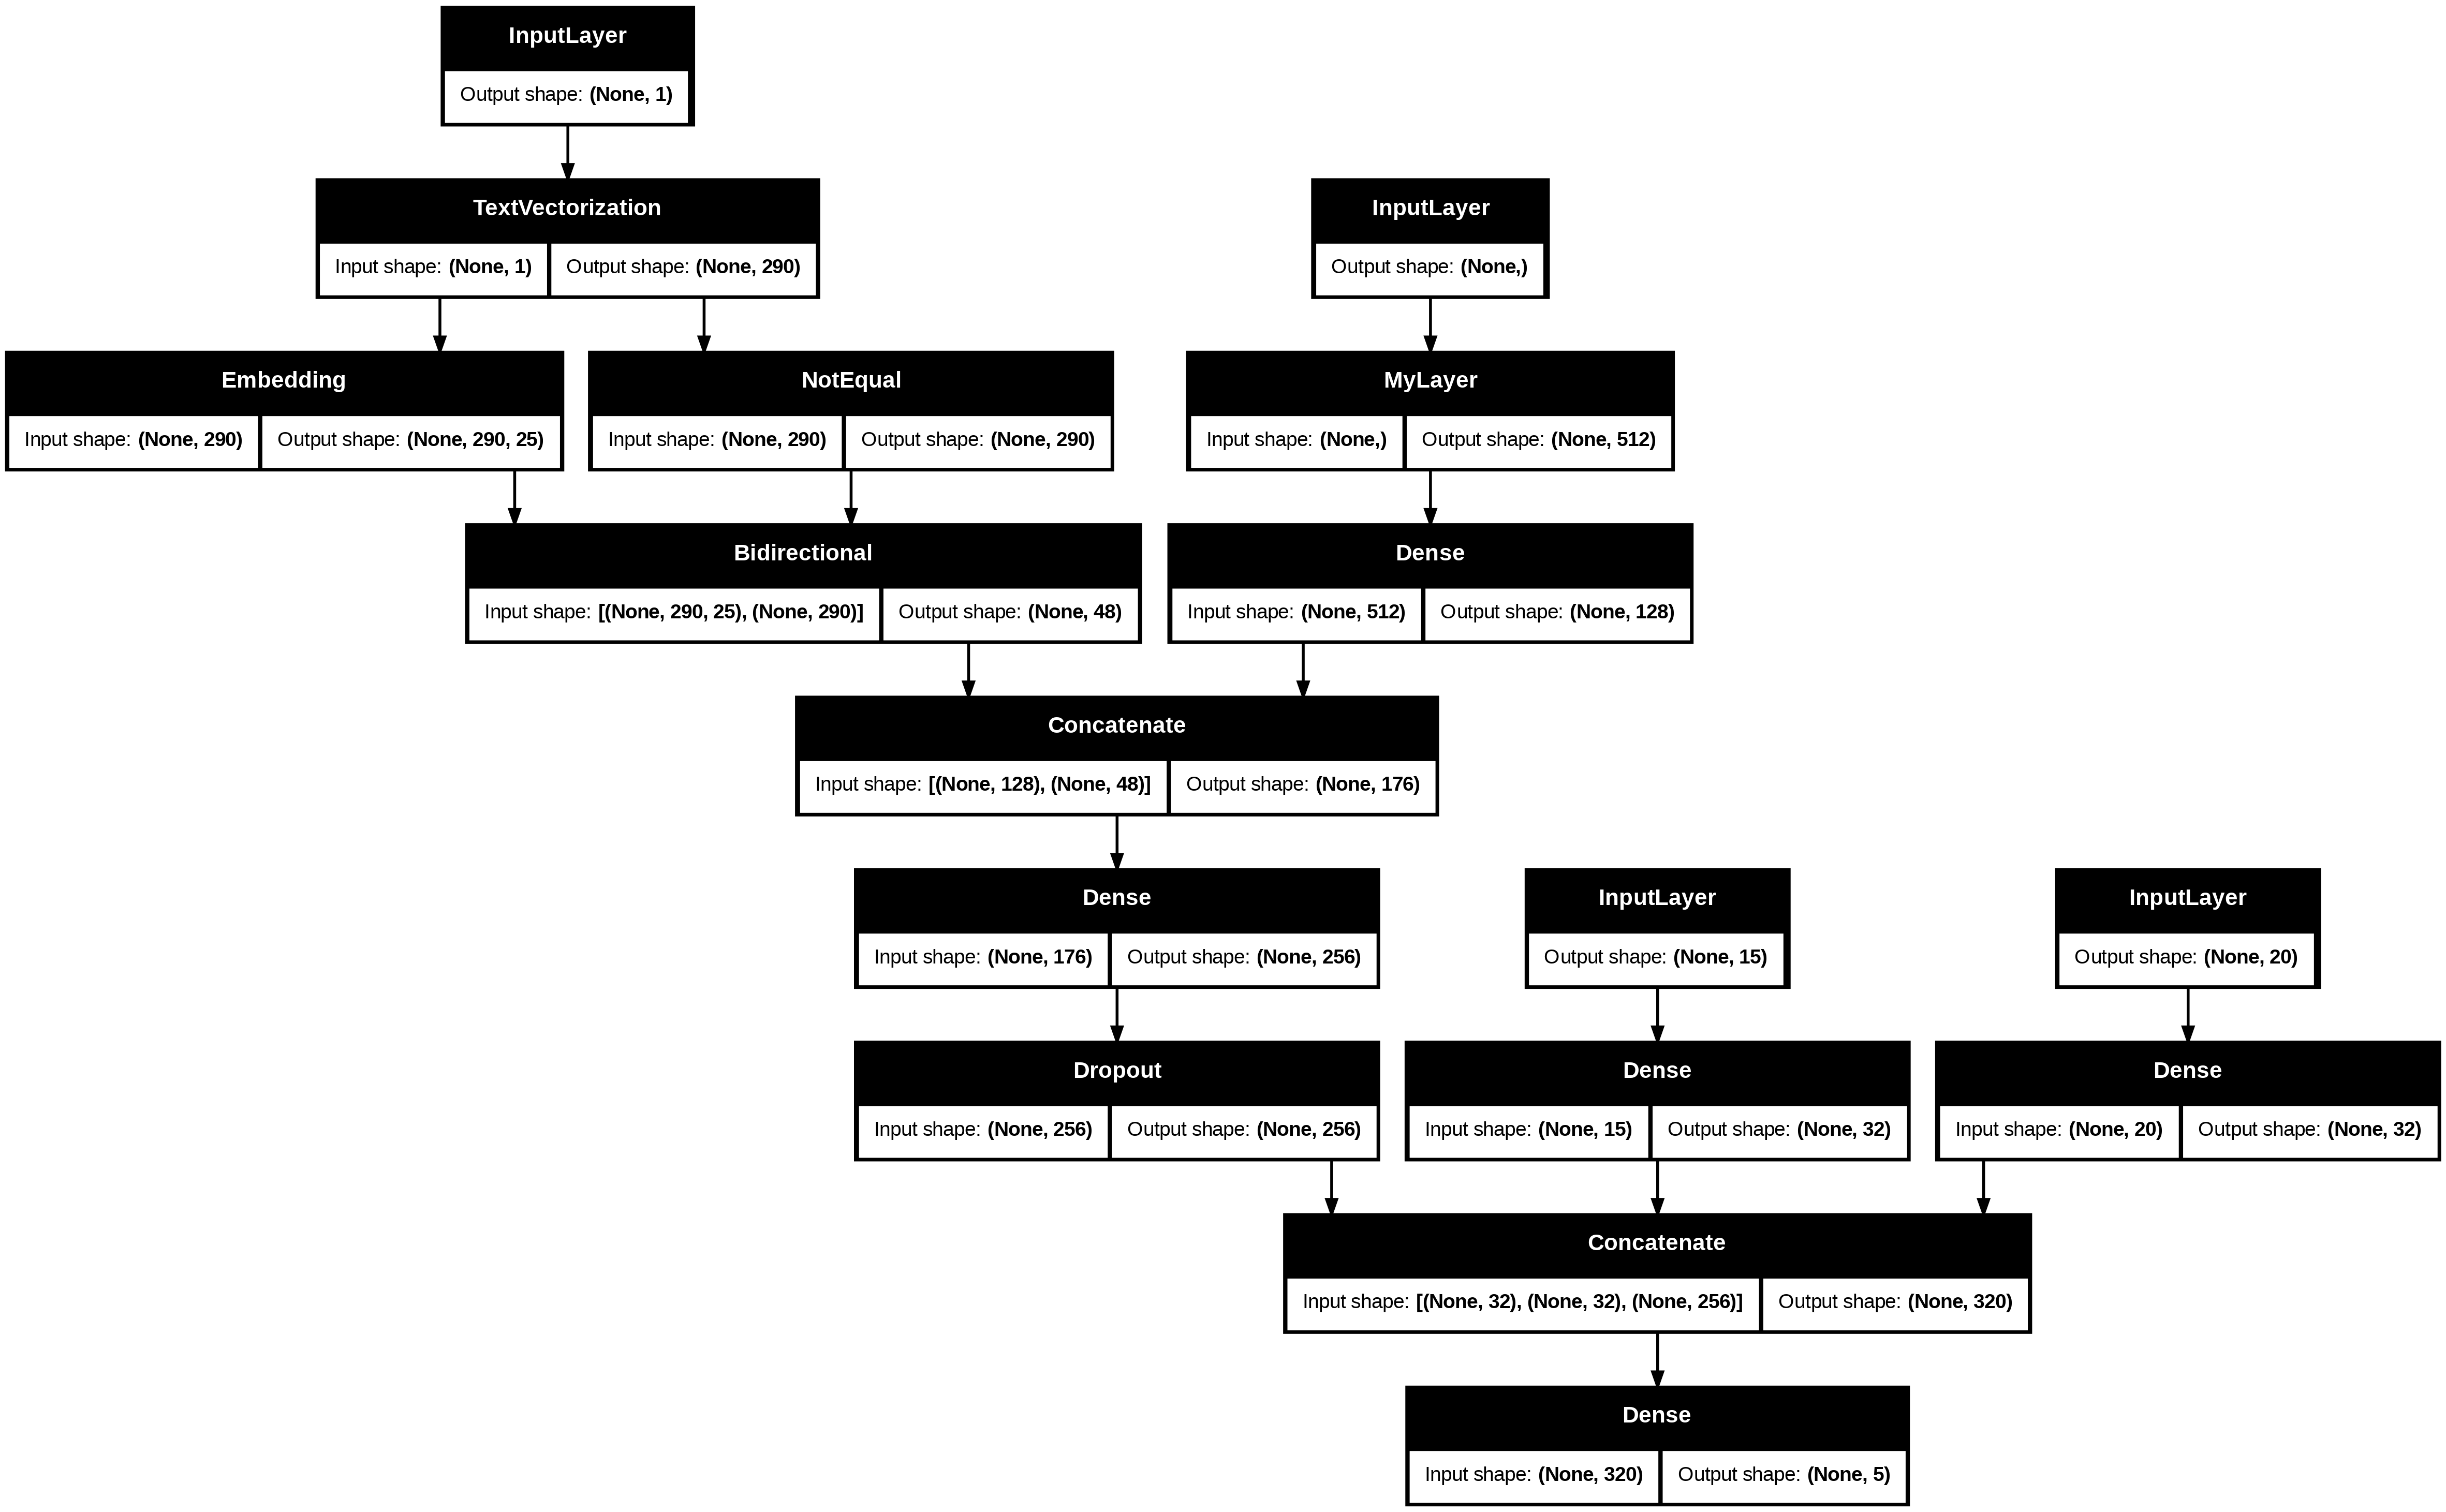

In [254]:
plot_model(tribrid_model,show_shapes=True)

In [223]:
# Creating out datasets using tf.data

train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                 train_total_lines_one_hot,
                                                                 train_sentences,
                                                                 train_chars))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))

train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#For validation dataset

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                 val_total_lines_one_hot,
                                                                 val_sentences,
                                                                 val_chars))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))

val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# For test dataset

test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                                 test_total_lines_one_hot,
                                                                 test_sentences,
                                                                 test_chars))

test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels))

test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [224]:
train_char_token_pos_dataset,val_char_token_pos_dataset,test_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [226]:
history_tribrid_model = tribrid_model.fit(train_char_token_pos_dataset, steps_per_epoch = int(0.1*len(train_char_token_pos_dataset)), epochs = 3, validation_data = val_char_token_pos_dataset)

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 279s 480ms/step - accuracy: 0.6343 - loss: 1.2195 - val_accuracy: 0.8003 - val_loss: 0.9831
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 268s 478ms/step - accuracy: 0.8110 - loss: 0.9697 - val_accuracy: 0.8205 - val_loss: 0.9515
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 248s 442ms/step - accuracy: 0.8208 - loss: 0.9519 - val_accuracy: 0.8346 - val_loss: 0.9346


In [227]:
#Make predictions

model_5_pred_probs = tribrid_model.predict(val_char_token_pos_dataset)
model_5_pred_probs

model_5_preds = tf.argmax(model_5_pred_probs, axis = 1)
model_5_preds

model_5_results = calculate_results(val_labels_encoded, model_5_preds)
model_5_results
#


945/945 ━━━━━━━━━━━━━━━━━━━━ 70s 74ms/step


{'accuracy': 83.46352442737985,
 'precision': 0.8336742486890425,
 'recall': 0.8346352442737985,
 'f1': 0.833234983992596}

# Compare all models results

In [230]:
all_models_results = pd.DataFrame({"model_0_baseline":baseline_results,
                                   "model_1_custom_token":model_1_results,
                                   "model_2_pretrained_token_embedding":model_2_results,
                                   "model_3_custom_char_embedding":model_3_results,
                                   "model_4_hybrid_char_token_embedding":hybrid_model_results,
                                   "model_5_pos_char_token_embedding":model_5_results})

all_models_results = all_models_results.transpose()
all_models_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token,80.666623,0.805172,0.806666,0.805264
model_2_pretrained_token_embedding,71.395472,0.713912,0.713955,0.710966
model_3_custom_char_embedding,65.642791,0.651399,0.656428,0.648130
model_4_hybrid_char_token_embedding,73.311929,0.731025,0.733119,0.729683
model_5_pos_char_token_embedding,83.463524,0.833674,0.834635,0.833235


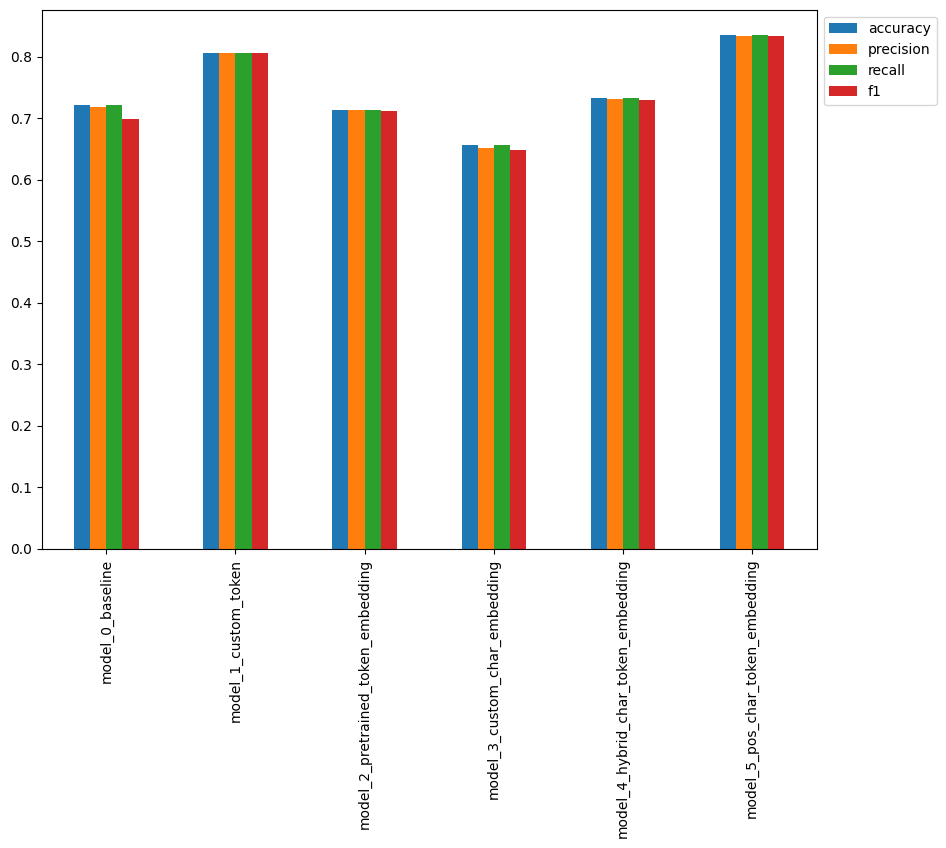

In [233]:
# Reduce the accuracy to same scale

all_models_results["accuracy"] = all_models_results["accuracy"] * 100
all_models_results.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0))

<Axes: >

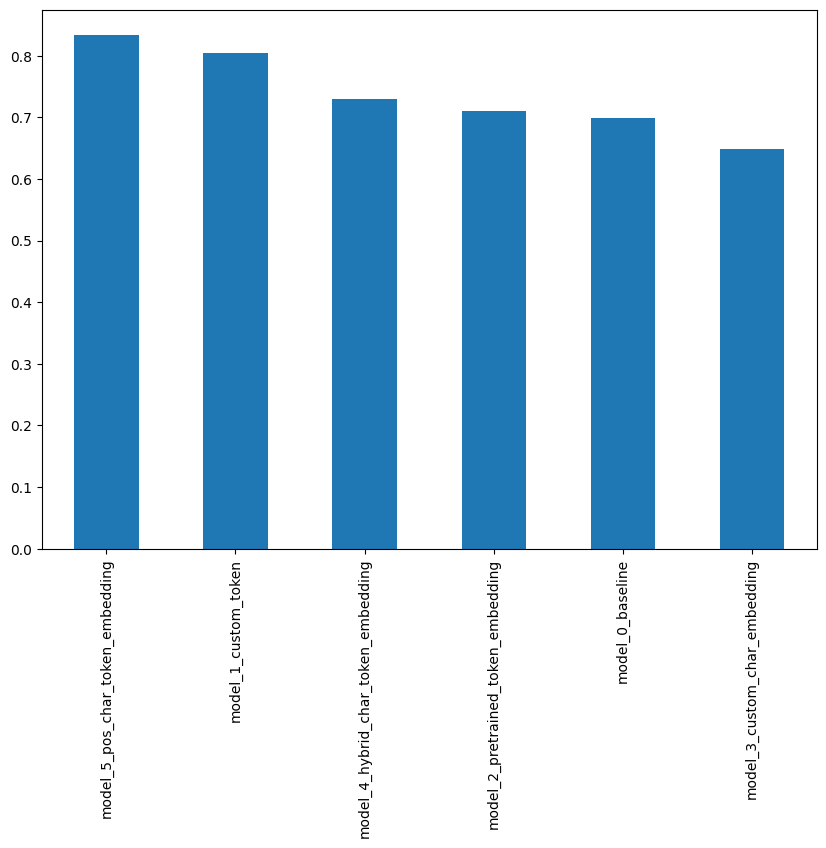

In [235]:
all_models_results.sort_values("f1", ascending = False)["f1"].plot(kind="bar",figsize=(10,7))

In [244]:
# Ensure 'MyLayer' is defined and decorated with @tf.keras.saving.register_keras_serializable()

import tensorflow as tf

@tf.keras.saving.register_keras_serializable()
class MyLayer(tf.keras.layers.Layer): # Example custom layer
    def __init__(self, **kwargs):
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Your layer's logic here
        pass

    def call(self, inputs):
        # Your layer's logic here
        pass

    def get_config(self):
        config = super(MyLayer, self).get_config()
        # Add any configurations specific to your layer if needed
        return config

# ... rest of your model definition using MyLayer ...

#Saving the model
tribrid_model.save("tribrid_model.keras")

# Loading the model and specifying the custom object
# Check if you have other custom objects or layers in your model
custom_objects = {'MyLayer': MyLayer,
                  # 'OtherCustomLayer': OtherCustomLayer, #add other custom layers if any
                 }
loaded_tribrid_model = tf.keras.models.load_model("tribrid_model.keras", custom_objects=custom_objects)

# Check if the model definition is the same as when it was saved
print(loaded_tribrid_model.summary())

# If the model summary shows missing layers or incorrect connections,
# review and ensure your current model definition matches the saved one.

ValueError: Layer node index out of bounds.
inbound_layer = <Dense name=dense_18, built=True>
inbound_layer._inbound_nodes = []
inbound_node_index = 0